In [1]:
# from google.colab import drive,files
# drive.mount("/content/gdrive", force_remount = True)

In [2]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [3]:
# import sys
# sys.stdout = open('/content/gdrive/My Drive/2/Mask_RCNN/output_logs', 'w')
# print('test')

In [4]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
# %tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
# !pip install -q keras==2.2.5
import keras
print(keras.__version__)
import random
import matplotlib.pyplot as plt

/home/kiprono/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


1.15.4
2.2.5


Using TensorFlow backend.


# BUILDING THE MODEL


In [5]:
os.chdir('../')
ROOT_DIR = './'

In [6]:
SAMPLES_DIR = './assets/datasets/fruits2'

DATA_DIR = './assets/datasets/fruits2'

# Directory to save logs and trained model


In [7]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git .

In [8]:
sys.path.append("./mrcnn")  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [9]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
 #!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "./mask_rcnn_coco.h5"

In [10]:
DEFAULT_LOGS_DIR = './assets/logs'

In [15]:
class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "fruits2"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU =   1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + baloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 200

    # Skip detections with the following confidence level
    DETECTION_MIN_CONFIDENCE = 0.90

    # Initial weights
    # INIT_IT = "imagenet"
    INIT_IT = "imagenet"

In [16]:
############################################################
#  Dataset
############################################################

class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
        assert subset in ["train", "val"],"subset can only be train or val"
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }

        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_project_fruits2.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.float32) #dtype=np.int32

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)       

## TRAINING - Code testing part

In [17]:
# import os
# os.environ['KERAS_BACKEND']='tensorflow'
# import sys
# sys.path.append('../')

# from config2 import *
# from dataset import NucleiDataset
# import numpy as np
# import model as modellib
# from model import log
# import utils
# import random

sys.path.append("./mrcnn")  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Training dataset
# dataset_train = NucleiDataset()
# dataset_train.add_nuclei(opt.train_data_root,'train')
# dataset_train.prepare()

dataset_train = BalloonDataset()
dataset_train.load_balloon(SAMPLES_DIR, "train")
dataset_train.prepare()

# Validation dataset
# dataset_val = NucleiDataset()
# dataset_val.add_nuclei(opt.val_data_root,'val')
# dataset_val.prepare()

dataset_val = BalloonDataset()
dataset_val.load_balloon(SAMPLES_DIR, "val")
dataset_val.prepare()

"""
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
 """   

'\n# Load and display random samples\nimage_ids = np.random.choice(dataset_train.image_ids, 4)\nfor image_id in image_ids:\n    image = dataset_train.load_image(image_id)\n    mask, class_ids = dataset_train.load_mask(image_id)\n    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)\n '

In [ ]:
# Create model in training mode
# model = modellib.MaskRCNN(mode="training", config=opt,
#                           model_dir=opt.MODEL_DIR)
config = BalloonConfig()

model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)

# Which weights to start with?
init_with = config.INIT_IT  # imagenet, coco, or last
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    if not os.path.exists(opt.COCO_MODEL_PATH):
        utils.download_trained_weights(opt.COCO_MODEL_PATH)
    
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(opt.COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    last_weight_path = \
    os.path.join(os.getcwd(),"assets/logs/fruits220210518T1629/mask_rcnn_fruits2_0141.h5")
    # Load the last model you trained and continue training
    model.load_weights(last_weight_path, by_name=True)
    

'''
train
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers 
    (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, 
    pass layers='heads' to the train() function.
2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. 
    Simply pass layers="all to train all layers.
'''

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            layers='all')

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=80,
            layers='all')

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=120,
            layers='all')
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/20,
            epochs=200,
            layers='all')
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/40,
            epochs=280,
            layers='all')

## Fine tune all layers
## Passing layers="all" trains all layers. You can also 
## pass a regular expression to select which layers to
## train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE/10,
#             epochs=200, 
#             layers="all")

# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE/20,
#             epochs=300,
#             layers='all')
# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE/50,
#             epochs=400,
#             layers='all')
# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE/100,
#             epochs=500,
#             layers='all')








Starting at epoch 0. LR=0.001

Checkpoint Path: ./assets/logs/fruits220210914T1631/mask_rcnn_fruits2_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

/home/kiprono/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/kiprono/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/kiprono/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/kiprono/.local/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/40
  2/200 [..............................] - ETA: 2:46:52 - loss: 4.8277 - rpn_class_loss: 1.6129 - rpn_bbox_loss: 2.3318 - mrcnn_class_loss: 0.8829 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

# TRAINING THE MODEL

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = BalloonDataset()
    dataset_train.load_balloon(SAMPLES_DIR, "train-images")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = BalloonDataset()
    dataset_val.load_balloon(SAMPLES_DIR, "val-images")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.


    # log_dir1="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir1, histogram_freq=1)

    # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir1,
    #                                     histogram_freq=1, write_graph=True, write_images=False)
    # custom_callbacks = [tensorboard_callback],


    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=500,
                layers='heads')  
    
#     model.save('64x3-CNN.model')

# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) #


In [ ]:
if __name__ == '__main__':
    print('Train')
    
    config = BalloonConfig()
    
    model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)
    
    weights_path = COCO_WEIGHTS_PATH
#     COCO_WEIGHTS_PATH = '../../../mask_rcnn_coco.h5'
    
    # Find last trained weights
    # weights_path = model.find_last()[1]
    
    
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
    
    train(model)

## SAVING MODEL STARTS INTO JSON


In [ ]:
history = model.keras_model.history.history
with open('train_fruits200.json', 'w') as fp:
    json.dump(history, fp)

AttributeError: ignored

NameError: ignored

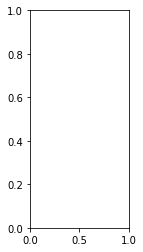

In [ ]:
epochs = range(200)
plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()

In [ ]:
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()

In [ ]:
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

# TESTING THE MODEL ON SAMPLE DATA

In [ ]:

# Local path to trained weights file
#ROOT_DIR = '/content/gdrive/My Drive/Balloon/trained/balloon20191026T0853'
COCO_MODEL_PATH = "./assets/logs/all20201229T1052/mask_rcnn_all_0200.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [ ]:
config = BalloonConfig()
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir="./trained", config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'fruit']

In [ ]:
file_names = [i for i in os.listdir(os.path.join(DATA_DIR,"val-images")) if i.startswith("_MG_")]
for _ in range(5):
    # Load a random image from the images folder
    file_ = random.choice(file_names)
    # file_ = "20151124T031733.705044_i2070j1370.png"
    print(file_)
    image = skimage.io.imread(os.path.join(DATA_DIR+"/val-images", file_))
    plt.figure(figsize=(15,15))
    plt.imshow(image)
 
    # Run detection/'
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    display_ = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])
    break


In [ ]:
r["rois"]